In [1]:
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import figure

import seaborn as sns


In [2]:
# raw_df = pd.read_csv('27612.02.05.2023.02.05.2024.1.0.0.ru.utf8.00000000.csv', delimiter=';', index_col=False)
raw_df = pd.read_csv('27612.02.05.2005.02.05.2024.1.0.0.ru.utf8.00000000.csv', delimiter=';', index_col=False)

In [3]:
def plot_df(df: pd.DataFrame, y_column, xtick_step, title='заголовок', value='показатель'):

    plt.figure(figsize=(24, 12), dpi=80)

    fig, ax1 = plt.subplots(1, figsize=(24,12))
    
    ax1.plot(df.index, df[y_column])
    ax1.set_xticks(df.index[::xtick_step])
    ax1.set_xticklabels(df.index[::xtick_step], rotation=90)

    plt.title(f"{title}")
    plt.xlabel('День')
    plt.ylabel(value)
    plt.grid(True)
    plt.legend()
    plt.show()

    # plt.savefig(name_output)
    # plt.close(fig)

In [4]:
raw_df = raw_df.drop([i for i in raw_df.columns if i not in ['Местное время в Москве (ВДНХ)', 'T', 'Po', 'U', 'RRR']], axis=1)

In [5]:
df = pd.DataFrame()

df['Time'] = raw_df['Местное время в Москве (ВДНХ)']
df['T'] = raw_df['T']

df[['day','month', 'year']] = df['Time'].str.split('.',expand=True)
df[['year', 'hour']] = df['year'].str.split(' ',expand=True)
df['Time'] = df['Time'].str.replace(' ', '_')

df = df.set_index('Time', drop=True)

df = df[['day', 'month', 'year', 'hour', 'T']]

df.dropna(inplace=True)

In [6]:
df.to_csv('weather_historicat_prepared.csv')

### Анализ данных по температуре

In [7]:
df.loc[df['T'] > 30]

,day,month,year,hour,T
Time,,,,,
06.08.2023_18:00,06,08,2023,18:00,30.2
06.08.2023_15:00,06,08,2023,15:00,31.1
06.08.2023_12:00,06,08,2023,12:00,30.5
27.08.2022_15:00,27,08,2022,15:00,30.8
26.08.2022_15:00,26,08,2022,15:00,30.2
...,...,...,...,...,...
27.05.2007_15:00,27,05,2007,15:00,30.6
14.07.2006_15:00,14,07,2006,15:00,30.6
13.07.2006_12:00,13,07,2006,12:00,30.2


In [8]:
df.describe()

,T
count,64838.000000
mean,6.760713
std,10.767111
min,-30.500000
25%,-0.700000
50%,6.200000
75%,15.200000
max,37.800000


In [9]:
print(f"min air_temperature - {df['T'].min()}" )
print(f"mean air_temperature - {df['T'].mean()}" )
print(f"max air_temperature - {df['T'].max()}" )
print(f"variance air_temperature - {df['T'].var()}" )
print(f"std air_temperature - {df['T'].std()}" )

min air_temperature - -30.5
mean air_temperature - 6.760712853573521
max air_temperature - 37.8
variance air_temperature - 115.93068392818772
std air_temperature - 10.767111215557668


In [10]:
df_heating_months = df.loc[df['month'].isin(['10', '11', '12', '01', '02', '03']) ] 

df_not_heating_months = df.loc[df['month'].isin([ '05', '06', '07', '08', '09']) ] 

print(f"Температура нар.воздуха по quantile(-0.95) в отопительные месяцы (20лет) - {df_heating_months['T'].quantile(1 - 0.95) } ")

print(f"Температура нар.воздуха по quantile(0.98) в неотопительные месяцы (20лет) - {df_not_heating_months['T'].quantile(0.98) } ")

Температура нар.воздуха по quantile(-0.95) в отопительные месяцы (20лет) - -14.7 
Температура нар.воздуха по quantile(0.98) в неотопительные месяцы (20лет) - 28.9 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

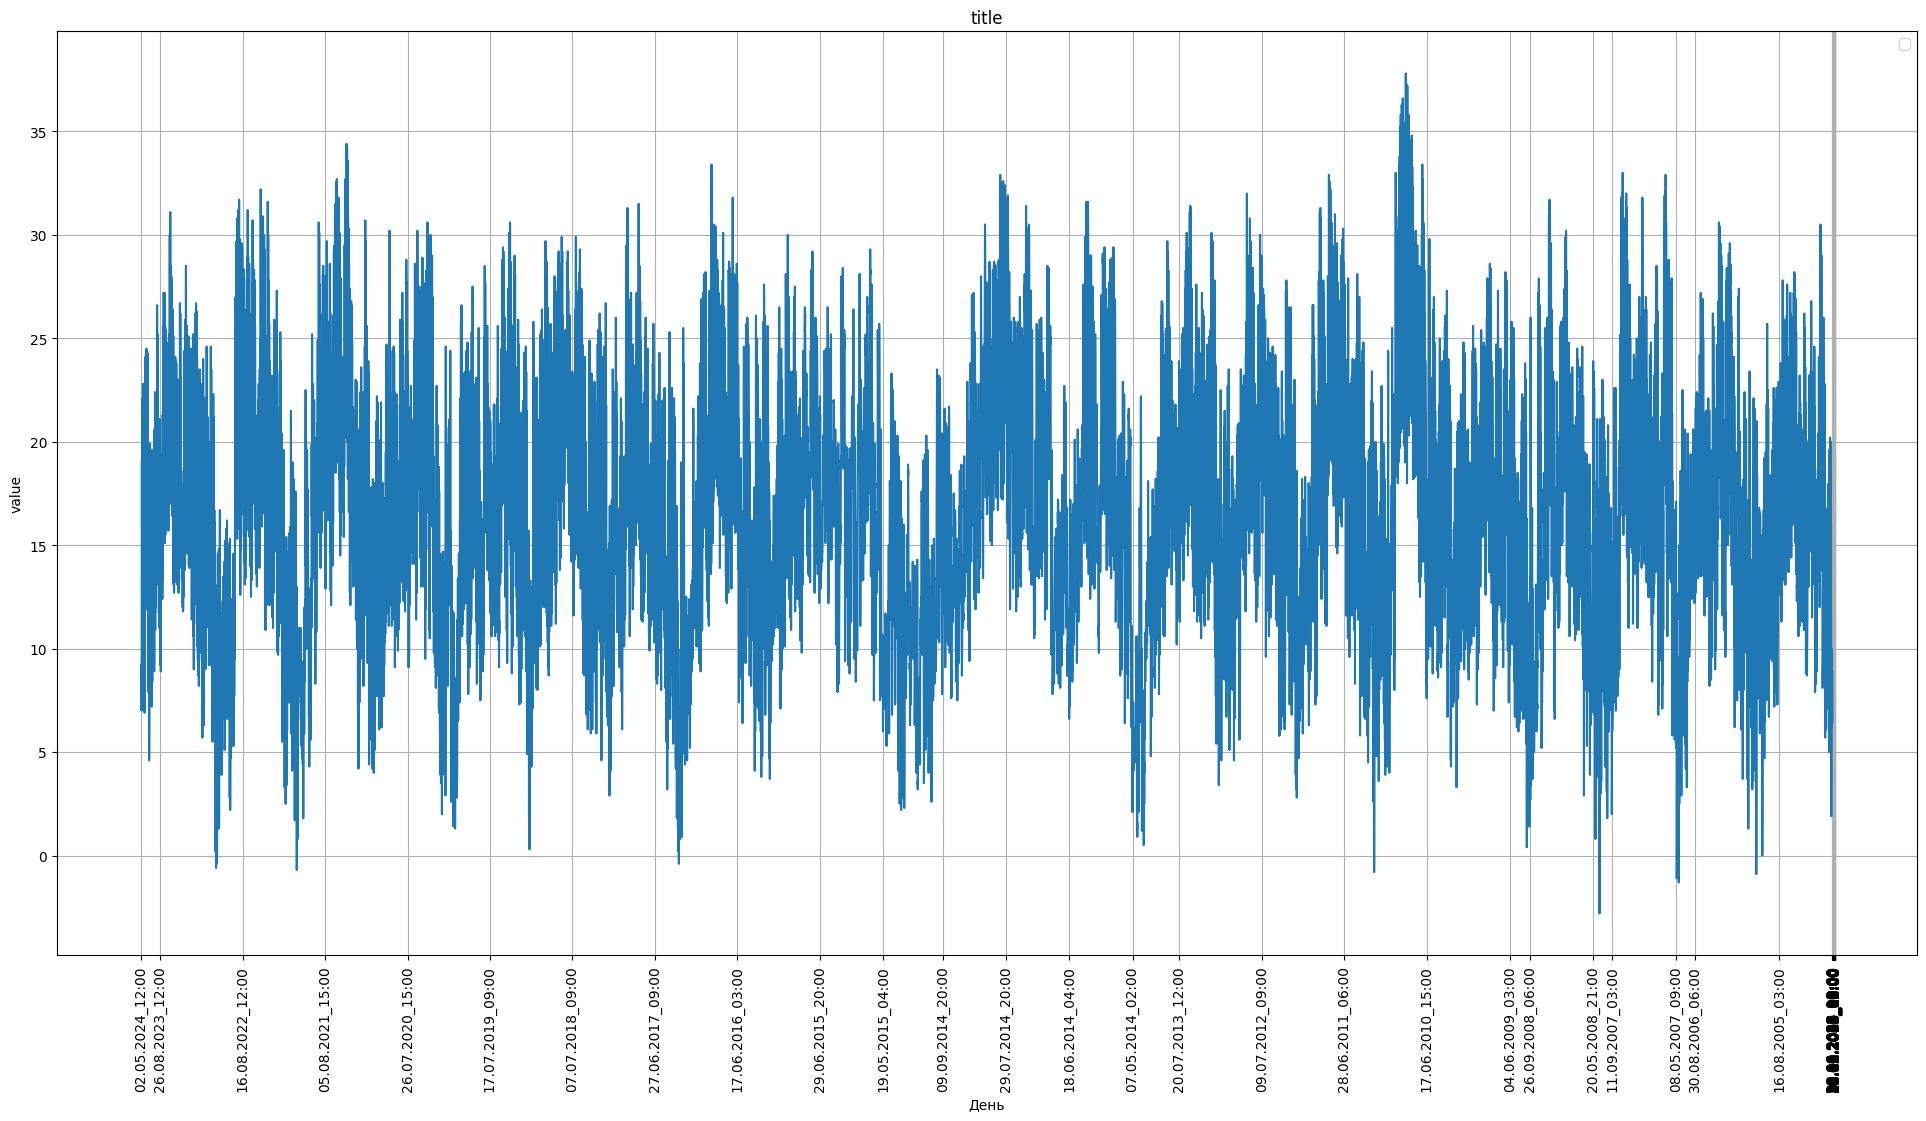

In [18]:


plt.figure(figsize=(24, 12), dpi=80)

fig, ax1 = plt.subplots(1, figsize=(24,12))

ax1.plot(df_not_heating_months.index, df_not_heating_months['T'])
ax1.set_xticks(df.index[::1000])
ax1.set_xticklabels(df.index[::1000], rotation=90)

plt.title("Статистика температуры нар.воздуха в летнее время, 20лет")
plt.xlabel('День')
plt.ylabel('температура воздуха')
plt.grid(True)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

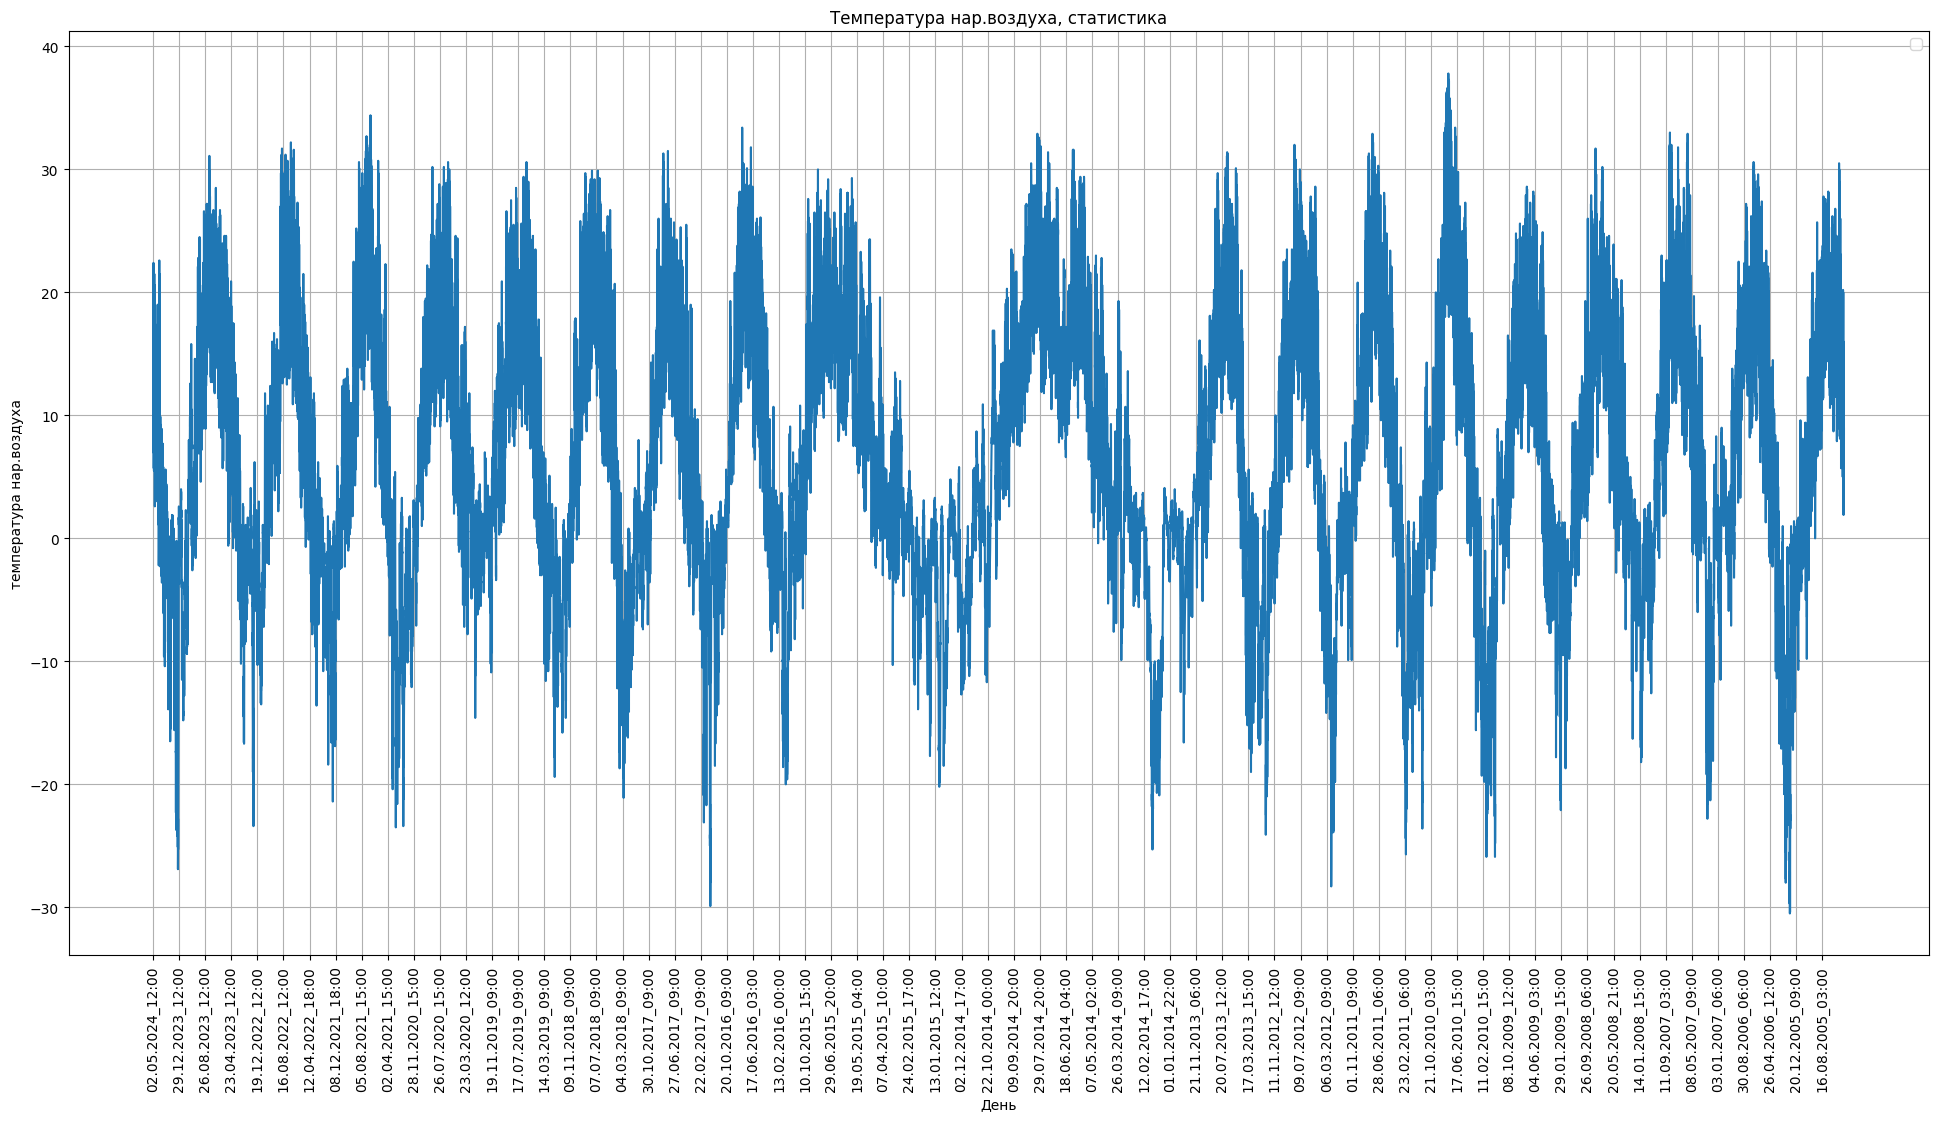

In [ ]:
plot_df(df, 'T', 1000, 'Температура нар.воздуха, статистика', 'температура нар.воздуха')